# Shoreline Refinement Experimentation 
<a target="_blank" href="https://colab.research.google.com/github/Wzesk/coastal_geotools_demo/blob/main/sample_shoreline_refinement.ipynb">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This notebook illustrates tools to refine satellite derived shorelines, particularly those extracted from low resolution imagery. 
This project draws extensive inspiration from the [Coastsal Project](https://github.com/kvos/CoastSat) described in detail here:

Vos K., Splinter K.D., Harley M.D., Simmons J.A., Turner I.L. (2019). CoastSat: a Google Earth Engine-enabled Python toolkit to extract shorelines from publicly available satellite imagery. Environmental Modelling and Software. 122, 104528. https://doi.org/10.1016/j.envsoft.2019.104528 (Open Access)

This refinement process is one module in a open source modular toolkit intended provide shoreline extraction with interchangable parts that take advantage of rapidly improving machine learning models.

You can interact and play with shoreline refinement at this web app: [refiner](https://refine.labs.littor.al/)


## install dependencies

This should install everything if you are working in colab.  

If you are working locally, it is easiest to install depenencies with anaconda as described in the readme.

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

prepath = "sample/"

if IN_COLAB:
    !git clone https://github.com/Wzesk/littoral_refine
    !pip install simplification
    !pip install geomdl
    !pip install numpy==1.26.4
    !pip install aquarel
    sys.path.append('/content/littoral_refine')
    # adjust path for colab
    prepath = "/content/littoral_refine/sample/"
else:
    print("not running in google colab, create a conda env using:  'conda env create -f environment.yml'")
    import matplotlib.pyplot as plt
    import numpy as np

not running in google colab, create a conda env using:  'conda env create -f environment.yml'


In [2]:
if IN_COLAB:
  from littoral_refine import extract_boundary, refine_boundary
else:
  #assuming notebook is running in same folder as dependencies
  import extract_boundary 
  import refine_boundary

## Mostly round island Example

The shoreline refinement process in the following steps:

1. Extract shoreline from the mask.  This includes some polyline simplifcation. 
2. Initiate new refiner object
3. Run refinement (normal, max slope derived thresholding or k-means clustering)
4. Visualize results


Setting inputs and extracting an intial boundary.  A buffer mask is also extracted. The buffer is onlyy used for testing, comparing to the refinement methods used in the [Coastsal Project](https://github.com/kvos/CoastSat).

In [3]:
# definte the inputs
mask_filepath = prepath + 'round/20241211T052119_20241211T052515_T43NCE_mask.png'
img_path =      prepath + 'round/20241211T052119_20241211T052515_T43NCE_sr.png'

shoreline, buffer, shoreline_filepath = extract_boundary.get_shoreline(mask_filepath,simplification=0.5,smoothing=2)

run the shore-normal refinement (one type of refinement) and visualize the results

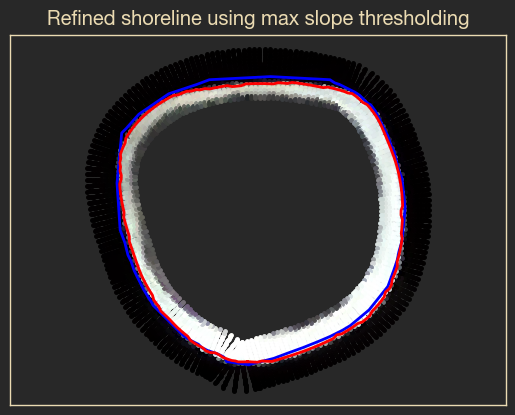

In [4]:
# initialize a new refiner
refiner = refine_boundary.boundary_refine(shoreline_filepath, img_path)
# use the normal thresholding to refine the extracted shoreline
refiner.normal_thresholding()
#visualize the result of refinement
refiner.visualize_results(draw_image=False,draw_sampling=True,title="Refined shoreline using max slope thresholding")

### Visualizing the NIR reflectance at Transects

The refined boundary in this approach matches the maximum slope in the changing NIR reflectance along the shorenormal transects.  These slopes are visualized below.  The slice input enables visualizing a subset of transects.

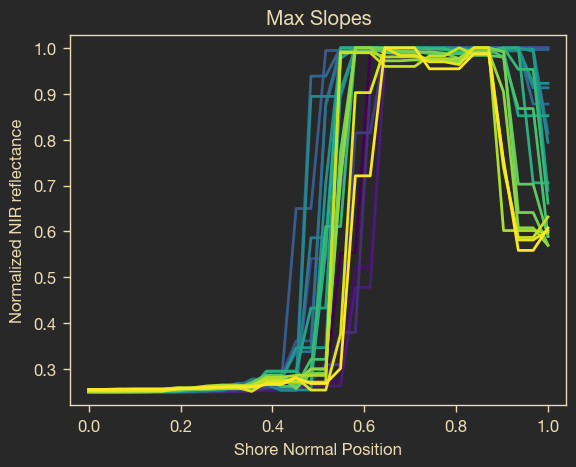

In [5]:
refiner.visualize_max_slopes(bounds=slice(0,25))

In addition to a max slope based refinement, k-means clustering can be used to refine the boundary

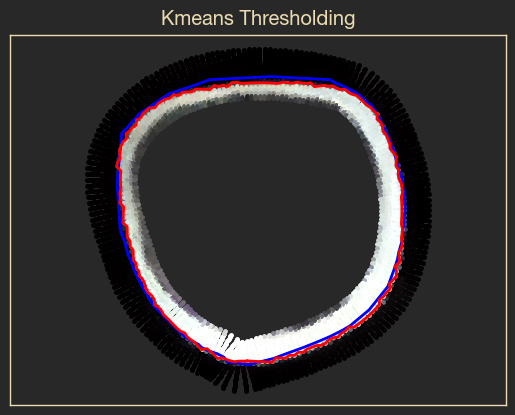

In [6]:
refiner.kmeans_thresholding()
refiner.visualize_results(draw_image=False,draw_sampling=True,title="Kmeans Thresholding")

This clustering can also be visualized to see how clustering is breaking up each transect.

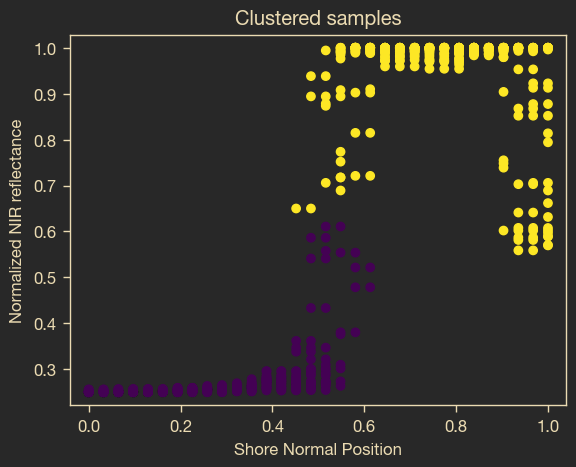

In [7]:
refiner.visualize_clusters(bounds=slice(0, 25))

## Non-Periodic Shoreline (island) Example

The refinement tool is part of a toolset specifically designed to monitor the evolution of small sandy islands.  We have begun testing on non-periodic shorelines.

In [9]:
# definte the inputs
np_mask_filepath = prepath + 'non-periodic/20240114T153611_20240114T153753_T19TDG_nir_mask.png'
np_img_path =      prepath + 'non-periodic/20240114T153611_20240114T153753_T19TDG_nir_up.png'

np_shoreline, np_buffer, np_shoreline_filepath = extract_boundary.get_shoreline(np_mask_filepath,simplification=0.5,smoothing=2,periodic=False)

the initial segmentation is interpreting breaking waves as land.

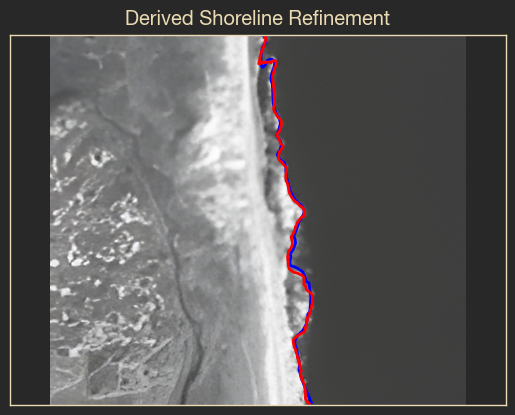

In [10]:
# initialize a new refiner
np_refiner = refine_boundary.boundary_refine(np_shoreline_filepath, np_img_path,periodic=False)
# use the normal thresholding to refine the extracted shoreline
np_refiner.normal_thresholding()
#visualize the result of refinement
np_refiner.visualize_results(draw_image=True,draw_sampling=False)

The refiner is not sampling far enough from the original solution to "fix" this defect.

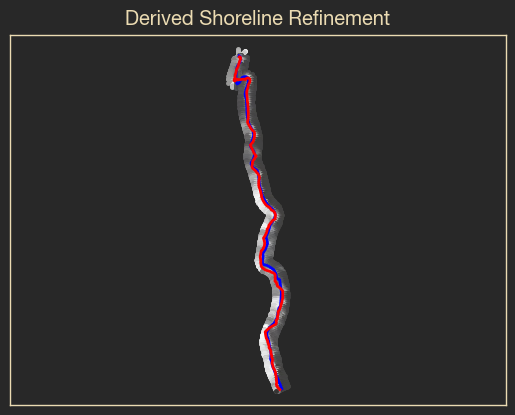

In [11]:
np_refiner.visualize_results(draw_image=False,draw_sampling=True)

This improves if we use a much simpler initial shoreline, and the sampling area is extended

float division by zero


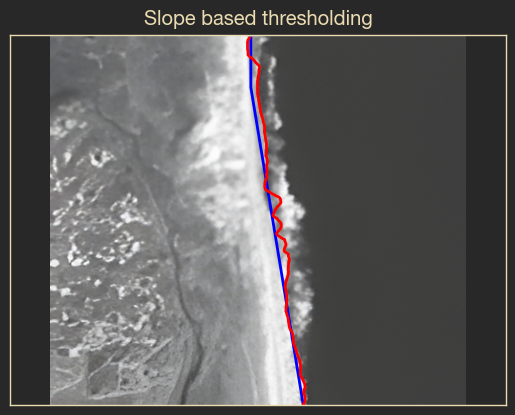

In [12]:
simple_shoreline_path = prepath + 'non-periodic/simple_shore_sl.csv'
# initialize a new refiner
np_refiner = refine_boundary.boundary_refine(simple_shoreline_path, np_img_path,periodic=False)
# use the normal thresholding to refine the extracted shoreline
np_refiner.sample_size = 30
np_refiner.normal_thresholding()
#visualize the result of refinement
np_refiner.visualize_results(draw_image=True,draw_sampling=False,title="Slope based thresholding")


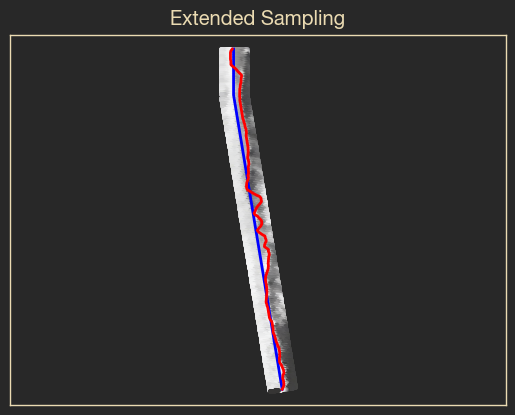

In [13]:
np_refiner.visualize_results(draw_image=False,draw_sampling=True,title="Extended Sampling")

K-means refinement picks up even less of the white water, works better at ignoring small chucks of high NIR reflectance.

float division by zero


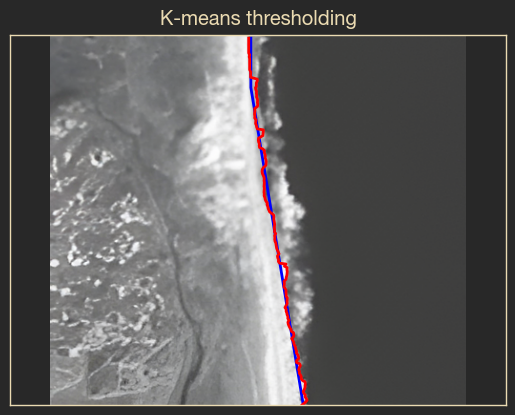

In [14]:
np_refiner.kmeans_thresholding()
np_refiner.visualize_results(draw_image=True,draw_sampling=False,title="K-means thresholding")

You can see where clustering is simple and where it is more ambiguous by adjusting the slice input.

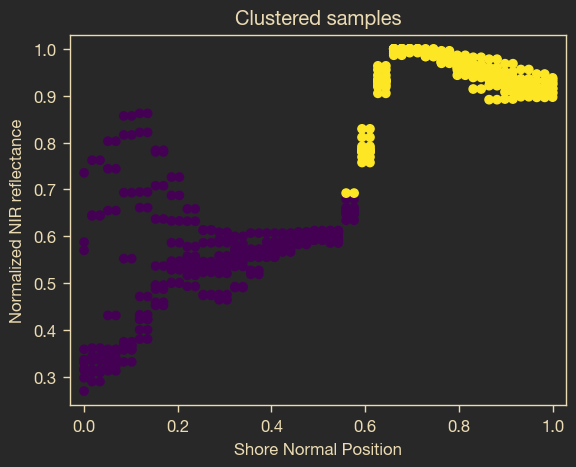

In [15]:
np_refiner.visualize_clusters(bounds=slice(0,10))

## Periodic Example

This refinement approach, in particular the slope based refinement, becomes more useful when monitoring small sandy islands that are far from round.

In [21]:
# definte the inputs
p_mask_filepath = prepath + 'periodic/20240116T052149_20240116T053608_T43NBF_nir_mask.png'
p_img_path =      prepath + 'periodic/20240116T052149_20240116T053608_T43NBF_nir_up.png'

p_shoreline, p_buffer, p_shoreline_filepath = extract_boundary.get_shoreline(np_mask_filepath,simplification=0.5,smoothing=2,periodic=True)

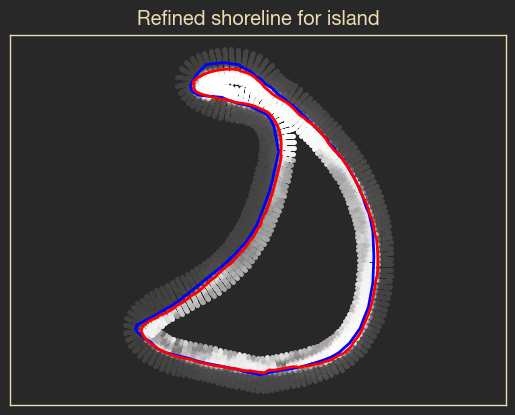

In [22]:
# initialize a new refiner
p_refiner = refine_boundary.boundary_refine(p_shoreline_filepath, p_img_path)
# use the normal thresholding to refine the extracted shoreline
p_refiner.normal_thresholding()
#visualize the result of refinement
p_refiner.visualize_results(draw_image=False,draw_sampling=True,title="Refined shoreline for island")

Max slope approach provides a consistent boundary.

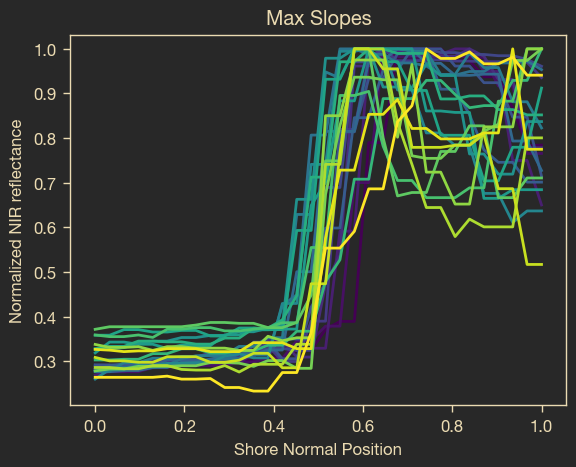

In [25]:
p_refiner.visualize_max_slopes(bounds=slice(0, 25))

with limited sampling, k-means also provides a useful refinement:

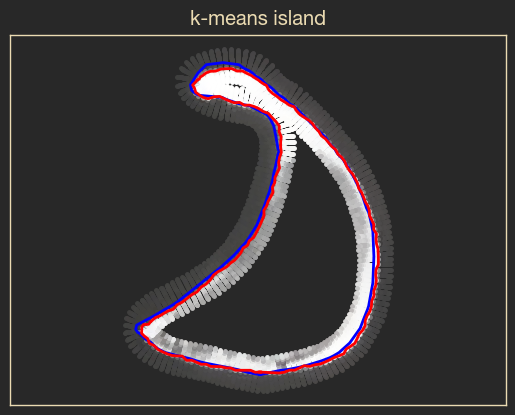

In [26]:
p_refiner.kmeans_thresholding()
p_refiner.visualize_results(draw_image=False,draw_sampling=True,title="k-means island")

With well defined clustering

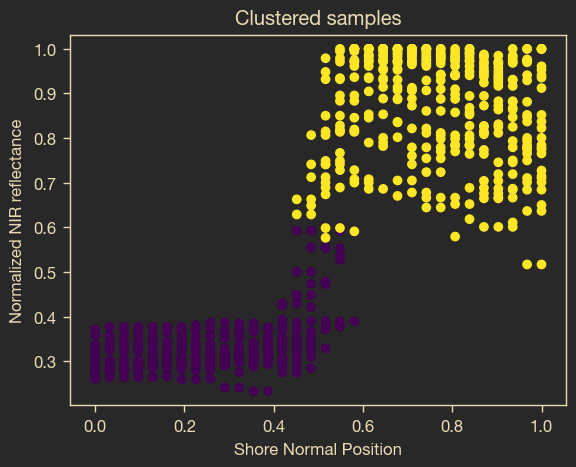

In [27]:
p_refiner.visualize_clusters(bounds=slice(0, 25))

but when small features of the island are smaller that the extent of the sampling, the k-means approach starts to break down.

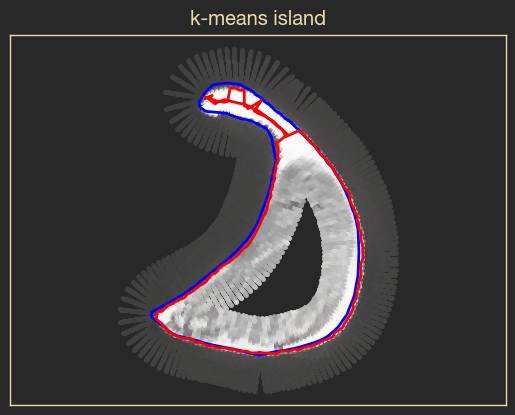

In [28]:
p_refiner.sample_size = 40
p_refiner.kmeans_thresholding()
p_refiner.visualize_results(draw_image=False,draw_sampling=True,title="k-means island")

### Get in touch!

This module and the broader toolkit is very much a work in progress.  We are working on building a modular pipeline to monitor small sandy islands, but we want to hear about other use cases, other features, and we are always looking for collaborates to help us build this open source project.  Connect by emailing: walter@littor.al